In [291]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import data

# Assuming that you have completed training the classifer, let us plot the training loss vs. iteration. This is an
# example to show a simple way to log and plot data from PyTorch.

# we neeed matplotlib to plot the graphs for us!
import matplotlib
# This is needed to save images 
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
verbose = False
path = './data/2013.txt'
corpus = data.Corpus(path, verbose)

In [332]:
class RNN_LanguageModel(nn.Module):
        
    def __init__(self, vocab_size, embed_size, nhidden, nlayers):
        super(RNN_LanguageModel, self).__init__()
        self.encoder = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, nhidden, nlayers)
        self.decoder = nn.Linear(nhidden, vocab_size)

    def forward(self, x, h0):
        y = self.encoder(x)
        y = y.unsqueeze(0)
        y, h1 = self.rnn(y, h0)
        y = self.decoder(y)
        return y, h1

In [313]:
device = torch.device("cpu")

vocab_size = len(corpus)
embed_size = 200
nhidden = 10
nlayers = 2
lm = RNN_LanguageModel(vocab_size, embed_size, nhidden, nlayers).to(device)
lm

RNN_LanguageModel(
  (encoder): Embedding(27738, 200)
  (rnn): RNN(200, 10, num_layers=2)
  (decoder): Linear(in_features=10, out_features=27738, bias=True)
)

In [397]:
# Validating RNN.
batch_size = 10
x0 = torch.tensor([0,1,2,3,5])
h0 = torch.zeros((nlayers, batch_size, nhidden))
#x1, h1 = lm(x0, h0)
# lm(corpus.data[:batch_size].to(torch.long), h0)
i = 0
source = corpus.data[i:batch_size].to(torch.long)
target1 = corpus.data[i+1:batch_size+1].to(torch.long)
target2 = corpus.data[i+2:batch_size+2].to(torch.long)
target3 = corpus.data[i+3:batch_size+3].to(torch.long)
criterion = nn.CrossEntropyLoss()
x1, h0 = lm(source, h0)
x2, h0 = lm(target1, h0)
x3, h0 = lm(target2, h0)
print(criterion(x1.squeeze(), target1))
print(criterion(x2.squeeze(), target2))
print(criterion(x3.squeeze(), target3))

tensor(10.1634, grad_fn=<NllLossBackward>)
tensor(10.2635, grad_fn=<NllLossBackward>)
tensor(10.2342, grad_fn=<NllLossBackward>)


In [340]:
class LSTM_LanguageModel(nn.Module):
        
    def __init__(self, vocab_size, embed_size, nhidden, nlayers):
        super(LSTM_LanguageModel, self).__init__()
        self.encoder = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, nhidden, nlayers)
        self.decoder = nn.Linear(nhidden, vocab_size)

    def forward(self, x, h0):
        y = self.encoder(x)
        y = y.unsqueeze(0)
        y, h1 = self.rnn(y, h0)
        y = self.decoder(y)
        return y, h1


lstm_lm = LSTM_LanguageModel(vocab_size, embed_size, nhidden, nlayers)
print lstm_lm

batch_size = 5
x0 = torch.tensor([0,1,10,3,5])
h0 = torch.zeros((nlayers, batch_size, nhidden))
lstm_lm.zero_grad()
x1, h1 = lstm_lm(x0, (h0, h0))
print(x1, h1)
# lstm_lm(corpus.data[:batch_size].to(torch.long), h0)

LSTM_LanguageModel(
  (encoder): Embedding(27738, 200)
  (rnn): LSTM(200, 10, num_layers=2)
  (decoder): Linear(in_features=10, out_features=27738, bias=True)
)
(tensor([[[-0.0211,  0.3336,  0.2109,  ...,  0.0989,  0.3161,  0.0185],
         [ 0.0069,  0.3308,  0.2661,  ...,  0.1106,  0.3192,  0.0528],
         [ 0.0310,  0.3173,  0.2313,  ...,  0.0940,  0.2909,  0.0560],
         [-0.0160,  0.4155,  0.1853,  ...,  0.0788,  0.3015,  0.0732],
         [ 0.0049,  0.3132,  0.2097,  ...,  0.1084,  0.3273,  0.0594]]],
       grad_fn=<AddBackward0>), (tensor([[[-5.0554e-03,  5.4847e-03, -3.1448e-02, -1.6865e-01,  5.6896e-01,
           2.4961e-02,  5.2508e-04, -4.0609e-02,  8.9158e-03, -7.7532e-02],
         [-1.2388e-01,  3.0588e-01, -5.1704e-01,  1.5570e-01,  4.3015e-01,
          -8.7585e-03,  7.4090e-02,  9.1461e-04, -5.8432e-01, -5.0778e-01],
         [ 4.5299e-01,  2.1395e-01, -1.0402e-01,  4.3592e-02,  3.7785e-03,
           1.2548e-01,  6.6925e-02, -2.8850e-02, -1.1214e-05, -2.2019e-

In [294]:
'''
Converts sequence to tensor.
'''
def seq2ix(seq, corpus):
    sequence = [corpus.word2ix[val] for val in seq.split()]
    return torch.tensor(sequence)

'''
Converts tensor output to actual words.
'''
def ix2word(data, corpus):
    to_word = lambda val, corpus: corpus.ix2word[val]
    return map(lambda x: to_word(x, corpus), data)


def batch(data, i, length):
    source = data[i:i+length]
    target = data[i+1:i+length+1].to(torch.long)
    return source, target

'''
Runs a single training epoch on the dataset.

Warning: One EPOCH took
CPU times: user 2min 45s, sys: 40.5 s, total: 3min 26s
Definitely needs to be trained on ICEHAMMER GPUs.
'''
def train(lm, corpus, seq_length, criterion=nn.CrossEntropyLoss(), lr=0.01, momentum=0.9, start = 0):
    lm.train()
    optimizer = torch.optim.SGD(lm.parameters(), lr=lr, momentum=momentum)
    total_loss = 0.
    data = corpus.data
    length = data.size(0)
    iterations = 1
    for i in range(start, length-seq_length, seq_length):
        lm.zero_grad()
        source, targets = batch(data, i, seq_length)
        source = source.to(torch.long)
        h0 = torch.zeros((nlayers, source.size(0), nhidden)) #TODO Come up with better initial hidden
        output, hidden = lm(source, h0)
        output = output.squeeze()
        loss = criterion(output, targets)
        total_loss += loss.item()
        iterations += 1
        loss.backward() 
        optimizer.step()
    return total_loss / iterations

def fit(lm, epochs, seq_length = 15):
    loss_history = []
    print("Running for {} epochs".format(epochs))
    for epoch in range(epochs):
        loss = train(lm, corpus, seq_length)
        print("Loss {}, Epoch {}".format(loss, epoch))
        loss_history.append(loss)
    return loss_history

def generate(lm, words, corpus, temperature=1.):
    sentence = []
    for word in words.split():
        x0 = seq2ix(word, corpus)
        batch_size = x0.size(0)
        h0 = torch.zeros((nlayers, batch_size, nhidden))
        x1, h1 = lm(x0, h0)
        word = torch.multinomial(x1.div(temperature).exp(), 1).squeeze()
        sentence.extend(ix2word([word], corpus))
    return ' '.join(sentence)

Running for 5 epochs
Loss 7.12376367769, Epoch 0
Loss 7.10441153055, Epoch 1
Loss 7.09085502294, Epoch 2
Loss 7.07644969237, Epoch 3
Loss 7.06449438176, Epoch 4
CPU times: user 46min 43s, sys: 4min, total: 50min 43s
Wall time: 48min 55s


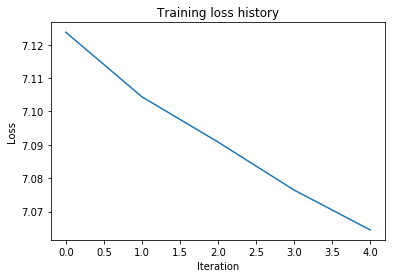

In [290]:
epochs = 5
%time loss_history = fit(lm, epochs)
if len(loss_history) > 1: # No need to plot if only one epoch of loss
    plt.plot(loss_history)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training loss history')
    plt.show()
else:
    print(loss_history)

In [ ]:
epochs = 1
%time loss_history = fit(lstm_lm, epochs)
print(loss_history)

In [343]:
import model

test = model.R